In [12]:
SAVE = True

n_jobs = 60

In [2]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS

MRT = [2, 3]
models = {}
for mrt in MRT:
    print(f'Loading models for MRT {mrt}')
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
    models[mrt] = eval_reallabor_utils.ModelCatalogue(results_dir)

Loading models for MRT 2
Loading models for MRT 3


In [3]:
initial_condition_version = 'unit vectors'        # 'trajectory', 'unit vectors'
hypers = [
    'train_on_data_until_timestep',
]
hyper_dtypes = [
    float,
]

In [ ]:
import sys
sys.path.append('..')
import torch as tc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import eval_reallabor_utils
import data_utils
import plotting_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN
from joblib import Parallel, delayed

MRT = [2, 3]
all_lyapunov = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        data_files = data_utils.get_data_files(test_data_dir,order_participants=True)
        participants = data_utils.get_participant_ids(data_files)
        mrt_lyapunov = []
        for p, df in tqdm(data_utils.zip_participants_data(test_data_dir, order_participants=True), total=len(data_files), desc=f'Calculating Lyapunov exponents for MRT {mrt}'):
            model_dirs = models[mrt].get_all_model_dirs(p)
            participant_lyapunov = []
            def process_model(model_dir):
                if model_dir is None:
                    return None
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                hyper_values = [model.args[h] for h in hypers]
                if initial_condition_version == 'trajectory':
                    x = tc.tensor(df[LABELS].to_numpy()).float()
                elif initial_condition_version == 'unit vectors':
                    x = tc.cat((tc.eye(len(LABELS)).float(), tc.zeros(len(LABELS)).float().unsqueeze(0)), 0)
                max_lyapunov = eval_reallabor_utils.max_lyapunov_exponent(model, x, 1000, T_trans=10, stop_at_convergence=True, tol=1e-6)
                return [*hyper_values, max_lyapunov.mean().item()]

            participant_lyapunov = Parallel(n_jobs=n_jobs)(delayed(process_model)(model_dir) for model_dir in model_dirs)
            participant_lyapunov = [result for result in participant_lyapunov if result is not None]

            if len(participant_lyapunov) > 0:
                participant_lyapunov = pd.DataFrame(participant_lyapunov, columns=[*hypers, 'lyapunov'])
                mrt_lyapunov.append(participant_lyapunov)

            # if p%100 > 20:
            #     break

        if len(mrt_lyapunov) > 0:
            mrt_lyapunov = pd.concat(mrt_lyapunov, axis=0, keys=participants, names=['participant'])
            all_lyapunov.append(mrt_lyapunov)

    all_lyapunov = pd.concat(all_lyapunov, axis=0, keys=MRT, names=['Sample'])
    for i, hyper in enumerate(hypers):
        all_lyapunov[hyper] = all_lyapunov[hyper].astype(hyper_dtypes[i])

Calculating Lyapunov exponents for MRT 3: 100%|██████████| 59/59 [02:05<00:00,  2.13s/it]


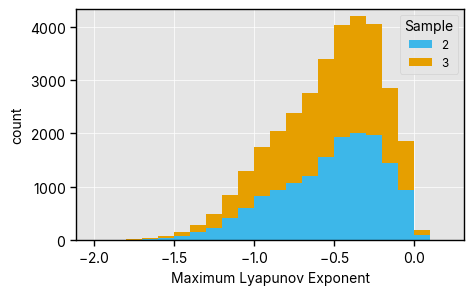

In [53]:
import plotting_utils
with PaperStyle():
    ax = all_lyapunov['lyapunov'].unstack('Sample').plot(kind='hist', bins=np.arange(-2, 0.21, 0.1), figsize=(5, 3), stacked=True)
    plotting_utils.adjust_ylim(ax, bottom=0, top=0.03)
    ax.set(xlabel='Maximum Lyapunov Exponent', ylabel='count')
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', 'max_lyapunov_exponent_distribution.svg'))
    plt.show()

In [38]:
slightly_smaller_than_zero = ((-0.01 < all_lyapunov['lyapunov']) & (all_lyapunov['lyapunov'] < 0)).sum() / len(all_lyapunov)
greater_than_zero = (all_lyapunov['lyapunov'] > 0).sum() / len(all_lyapunov)

print(f'Proportion of models with slightly smaller than zero lyapunov exponents: {slightly_smaller_than_zero:.4f}')
print(f'Proportion of models with greater than zero lyapunov exponents: {greater_than_zero:.4f}')

Proportion of models with slightly smaller than zero lyapunov exponents: 0.0166
Proportion of models with greater than zero lyapunov exponents: 0.0061


In [39]:
len(all_lyapunov)

32660

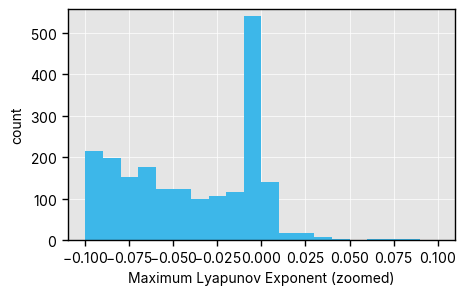

In [36]:
with PaperStyle():
    ax = all_lyapunov.loc[all_lyapunov['lyapunov'].abs() < 0.1, 'lyapunov'].hist(bins=np.arange(-0.10, 0.100001, 0.01), figsize=(5, 3))
    ax.set(xlabel='Maximum Lyapunov Exponent (zoomed)', ylabel='count')
    plotting_utils.adjust_ylim(ax, bottom=0, top=0.03)
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', 'max_lyapunov_exponent_distribution_zoomed.svg'))
    plt.show()

In [ ]:
all_lyapunov.loc[all_lyapunov['lyapunov'] > 0].groupby()

train_on_data_until_timestep  lyapunov
mrt participant                                            
2   13          198                         184.0  0.046448
    14          69                          102.0  0.000653
                151                         156.0  0.000190
    15          193                         178.0  0.000036
                225                         196.0  0.003620
...                                           ...       ...
3   267         204                         189.0  0.047137
    269         22                          114.0  0.000136
                296                         276.0  0.000376
    270         340                         269.0  0.027974
    271         42                           95.0  0.000946

[196 rows x 2 columns]